# Training a multi-layered neural network
## Multi-layer neworks

이전 단원까지는 손글씨 숫자를 인식하는 단일 레이어의 네트워크를 사용했습니다. 이제는 레이어를 추가하여 정확도 측면에서 좀 더 나은 성능을 얻을 수 있는지 봅시다. 

이전 단원에서 정의했던 모든 함수를 부르기 위해, 이전 단원과 같이 pytorchcv helper를 사용합시다.

In [1]:
!pip install torchinfo

In [2]:
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
from torchinfo import summary

from pytorchcv import load_mnist, train, plot_results
load_mnist(batch_size=128)

멀티레이어 네트워크에서는 **hidden layer**가 추가됩니다.
![An image showing a multi-layer network with a hidden layer between the input layer and the output layer.](./images/dense-multilayer-network.png)

이 레이어는 뉴럴넷이 얼마나 많은 파라미터를 가질 것인지에 영향을 미치는 많은 뉴런을 포함할 수 있습니다. 네트워크에 매개변수가 많을수록 훈련에 더 많은 파라미터가 필요합니다.

하지만 많은 것이 항상 좋은 것은 아닙니다. 많은 뉴럿넷 파라미터는 **overfitting** 방지를 위해 데이터셋의 크기를 고려하여 선택해야 합니다. 

멀티레이어 네트워크 구조는 아래의 모양과 같습니다.
![An image showing the network layer structure as it's broken down into layers.](./images/multilayer-network-layers.png)

여기서 주목해야할 점은 **ReLU**라는 비선형 활성화 함수 레이어입니다. 뉴럴넷이 상당한 표현력을 갖는 이유가 비선형 활성화 함수가 포함되기 때문입니다. 실제로, 네트워크가 선형 레이어로만 구성된 경우 본질적으로 하나의 선형 레이어와 동일하다는 것을 수학적으로 증명할 수 있습니다. 따라서 레이어 사이에 비선형 함수를 추가하는 것은 매우 중요합니다.

아래는 사용 빈도가 높은 두 가지의 활성화 함수의 모양을 나타냅니다.

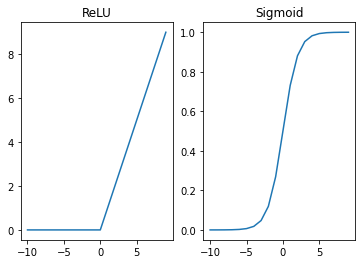

In [3]:
def plot_function(f, name=''):
    plt.plot(range(-10,10), [f(torch.tensor(x, dtype=torch.float32)).item() for x in range(-10,10)])
    plt.title(name)

plt.subplot(121)
plot_function(torch.relu,'ReLU')
plt.subplot(122)
plot_function(torch.sigmoid,'Sigmoid')

Pytorch 네트워크에서는 `Sequential`을 사용하여 아래와 같이 정의할 수 있습니다.

In [4]:
net = nn.Sequential(
    nn.Flatten(), 
    nn.Linear(784,100),     # 784 inputs, 100 outputs
    nn.ReLU(),              # Activation Function
    nn.Linear(100,10),      # 100 inputs, 10 outputs
    nn.LogSoftmax(dim=0))

summary(net,input_size=(1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               --                        --
├─Flatten: 1-1                           [1, 784]                  --
├─Linear: 1-2                            [1, 100]                  78,500
├─ReLU: 1-3                              [1, 100]                  --
├─Linear: 1-4                            [1, 10]                   1,010
├─LogSoftmax: 1-5                        [1, 10]                   --
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
Total mult-adds (M): 0.08
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.32
Estimated Total Size (MB): 0.32

여기에서 `torchsummary.summary` 함수는 유용한 다른 정보와 함께 상세한 레이어별 네트워크 구조를 출력합니다. 특별히 우리는 네트워크의 파라미터 수를 알 수 있습니다. multi-layered perceptron을 학습해봅시다.

Epoch  0, Train acc=0.929, Val acc=0.951, Train loss=0.023, Val loss=0.022
Epoch  1, Train acc=0.959, Val acc=0.960, Train loss=0.022, Val loss=0.022
Epoch  2, Train acc=0.966, Val acc=0.961, Train loss=0.021, Val loss=0.022
Epoch  3, Train acc=0.970, Val acc=0.963, Train loss=0.021, Val loss=0.022
Epoch  4, Train acc=0.972, Val acc=0.961, Train loss=0.021, Val loss=0.022


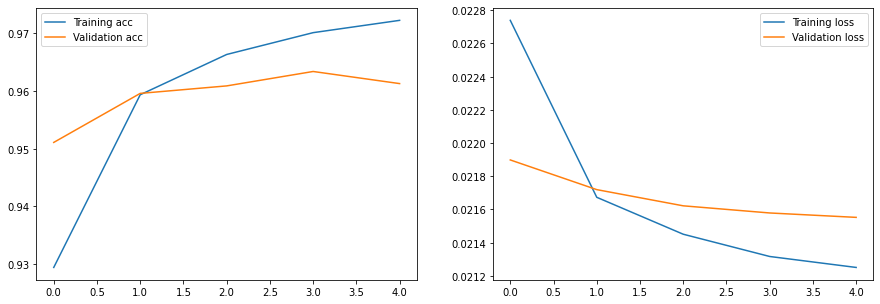

In [5]:
hist = train(net, train_loader, test_loader, epochs=5)
plot_results(hist)

다음 사항을 유의하세요.
    - 이 네트워크는 이 전 단원에서 학습했던 단일 레이어보다 표현력이 더 우수합니다. 그러므로 100%에 가까운 학습 정확도를 기록하였습니다. 
    - 검증 정확도가 향상되지 않으면, 모델이 일반화 할 수 있는 능력에 거의 도달했으며 추가 학습을 통해 overfitting이 발생할 수 있음을 의미합니다.

## Class-based network definitions
Sequential 스타일을 레이어 목록으로 사용하여 모델을 정의하는 것은 매우 편리해 보이지만 일부 제한적입니다. 어떤 시점에서 공유 가중치 또는 레이어 간의 일부 비선형 연결을 포함하는 더 복잡한 네트워크를 정의해야 할 수도 있습니다.ㅡ

In [6]:
from torch.nn.functional import relu, log_softmax

class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        self.flatten = nn.Flatten()
        self.hidden = nn.Linear(784,100)
        self.out = nn.Linear(100,10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.hidden(x)
        x = relu(x)
        x = self.out(x)
        x = log_softmax(x,dim=0)
        return x

net = MyNet()

summary(net,input_size=(1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
MyNet                                    --                        --
├─Flatten: 1-1                           [1, 784]                  --
├─Linear: 1-2                            [1, 100]                  78,500
├─Linear: 1-3                            [1, 10]                   1,010
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
Total mult-adds (M): 0.08
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.32
Estimated Total Size (MB): 0.32

우리는 위의 네트워크에서 `Sequential`로 정의된 레이어 구조와 같지만 더욱 명확하게 정의된 네트워크를 확인할 수 있습니다. 사용자 정의 뉴럴넷은 [torch.nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html) 클래스를 상속하여 구현할 수 있습니다.

클래스 정의는 2개 부분으로 구성됩니다.
- 생성자(`__init__`)에서는 네트워크에 포함할 모든 레이어를 정의합니다. 이 레이어들은 클래스의 내부 변수로 저장되며, Pytorch는 자동으로 이 레이어들의 파라미터가 학습할 때 최적화 될 것으라는 것을 인식합니다. PyTorch는 학습 가능한 모든 파라미터를 찾기 위해 `parameters()` 함수를 사용하며, `nn.Module`은 모든 서브 모듈로부터 학습 가능한 모든 파라미터들을 자동으로 수집할 것입니다.
- `forward` 함수에서는 뉴럴넷의 순방향 계산을 수행하는 방법을 정의합니다. 우리의 경우, Tensor x가 `flatten` 함수로 시작하여 마지막 선형 층에 도달할 때까지의 모든 레이어와 활성 함수를 통과하도록 구현입니다. out = net(x)를 작성하여 일부 입력 데이터 x에 대해 뉴럴넷을 적용하면 forward 함수가 호출됩니다.

사실, `Sequential` 네트워크는 매우 유사한 방법으로 표현되었지만, 단지 레이어들을 리스트 형태로 저장하고 순방향 경로에서 순서대로 적용할 뿐입니다. 우리는 이러한 프로세스를 좀 더 명시적으로 표현할 수 있으며, 이는 결과적으로 더 나은 유연성을 제공할 것입니다. 이것이 클래스를 통한 뉴럴넷 정의방법이 더욱 권장되고 더 적합한 이유입니다.

이제 우리는 네트워크를 학습하여 전과 유사한 결과를 얻을 것입니다.

Epoch  0, Train acc=0.931, Val acc=0.954, Train loss=0.023, Val loss=0.022
Epoch  1, Train acc=0.960, Val acc=0.959, Train loss=0.022, Val loss=0.022
Epoch  2, Train acc=0.966, Val acc=0.962, Train loss=0.021, Val loss=0.022
Epoch  3, Train acc=0.970, Val acc=0.966, Train loss=0.021, Val loss=0.021
Epoch  4, Train acc=0.972, Val acc=0.965, Train loss=0.021, Val loss=0.022


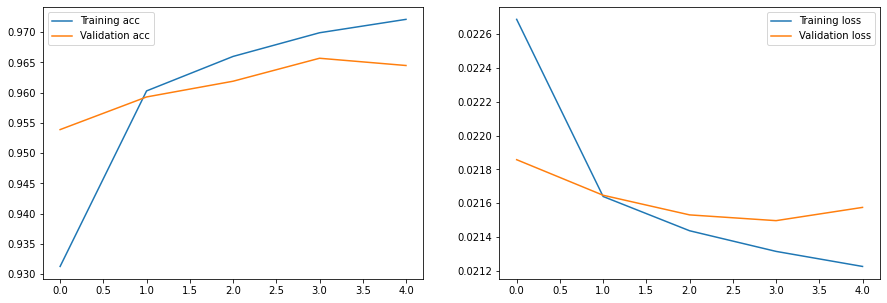

In [7]:
hist = train(net, train_loader, test_loader, epochs=5)
plot_results(hist)

## Takeaway
멀티 레이어 네트워크는 단일 레이터에 비해 높은 정확도를 달성할 수 있지만 컴퓨터 비전에서는 완벽하지는 않습니다. 이미지에서는 이미지 내에서 포지션과 관계없이 물체를 인식하는 데 도움이 되는 많은 구조적 패턴이 있지만, 이러한 패턴을 추출하고 선택적으로 찾는 것을 허용하지 않습니다. 다음 단원에서는 컴퓨터 비전에서 효과적으로 사용할 수 있는 특수한 유형의 뉴럴넷을 알아봅시다.